In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
#fully paid, Charged off 레이블만 있는 dataset
df = pd.read_csv('loan_data.csv', low_memory=False)

In [3]:
accept = pd.read_csv('accepted_2007_to_2018Q4.csv', low_memory=False)

In [4]:
accept.shape

(2260701, 151)

In [5]:
df.shape

(218460, 151)

# Lending Club Business Model Step

*Lending Club provides the “bridge” between investors and borrowers*

1. 대출자 신청 : 대출 신청 개인은 온라인 플랫폼을 통해 대출 신청(직업 정보, 소득, 신용점수, 대출목적 등 개인 및 금용정보 제공)

2. 신용 평가 : 랜딩 클럽은 위험 예측 모델 사용하여 대출자의 신용도 평가한다. 그들은 대출자 정보, 신용 점수 및 과거 데이터를 평가하여 상환 가능성을 결정하고 승인된 대출에 적절한 이자율을 할당한다. 
If approved, the offer will include options for the fixed monthly payment for a 36 and 60-month loan, with the interest rates for each.

-> 'installment', 'interest rates' 부여


3. 투자자 참여 : 승인된 대출은 플랫폼에서 투자자가 이용할 수 있다. 투자자는 대출 내역을 검토하고 일부 또는 전체에 자금을 지원할 지 결정한다.

4. 대출금 지급 : 대출이 완료되면 대출금을 대출자에게 지급한다. 

5. 대출 서비스 : 랜딩 클럽은 대출자로부터 매달 상환금을 받고 투자자에게 자금을 분배하면서 상환 과정을 관리한다. 
---

### Lending Club Domain
- That’s where debt-to-income ratio comes in. An applicant’s combined debts can’t add up to more than 40% of their gross income.

- However, in grades A–F, almost every type of loan is larger for the joint than for the individual.

---


# 프로젝트 정의

1. 목적 : 대출자 승인자의 채무불이행(Charged Off) 여부 예측을 통한 투자자들의 위험 최소화 시켜 투자자들의 원활한 투자를 이끌어 내는 것이 중요합니다. 이는 랜딩클럽의 투자자들이 p2p대출에 대한 신뢰와 건전의 거래의 양을 늘리게 될 것이라 기대합니다. 

- 투자자의 입장 : 대출자의 프로필, 신용도 및 대출 특성에 따라 신중하게 대출을 선택함으로써 채무 불이행의 위험을 피하면서 높은 이자율로 수익을 추구합니다. 위험부담과 이자율의 균형을 유지하면서 투자 포트폴리오를 구축하는 것이 중요합니다.

2. 데이터 범위 : 대출 승인 데이터 셋 중 loan_status : Charged Off / fully paid 인 행
- 데이터 셋의 특징 : 대출 데이터 세트는 랜딩클럽 플랫폼에서 발행된 과거 대출에 대한 포괄적인 정보를 포함합니다.


---

# Feature Drop

In [13]:
def make_na_table(group, df=df):
    na_table = PrettyTable()
    na_table.field_names = ["변수명", "결측치 개수", "전체 비율"]
    for col in group:
        na_cnt = df[col].isna().sum()
        total_rows = df.shape[0]
        ratio = (na_cnt / total_rows) * 100
        na_table.add_row([col, na_cnt, f'{ratio:.2f}%'])
    print(na_table)
    

def get_uv1_list(group,n,df):
    l = []
    for col in group:
        nu = df[col].nunique()
        
        if nu == n :
            l.append(col)
            print(f'{col} NU: {nu}')
            print(df[col].unique(), '\n')
            print('-'*70)
        #else:
            #print('!!!TOO MANY!!!\n', df[col].unique()[1:5])
    return l

       

## 1. 프로젝트 목적에 따른 범위를 벗어나는 변수
- loan_status : Charged off, fully paid 
이 프로젝트의 목표는 투자자가 투자 결정을 내리기 전에 대출금이 상환될지 여부를 예측하는 것입니다.   
그래서 현재 대출중인 상태(Current)와 관련된 특성 제거합니다.
- 랜딩 클럽의 **대출 승인 시점**에서 투자자가 알 수 있는 변수 (과거 대출 이력, 신용 정보, 개인정보)

### 데이터 셋 대출관련 시점
-> 데이터 셋에서 대출 과정중에 생성된 변수가 포함되어 있다.

In [6]:
date_col = [col for col in df.columns if 'date' in col]
date_col.extend(['issue_d','last_pymnt_d','next_pymnt_d'])

In [7]:
#Charged off, fully paid 레이블만 있는 데이터셋의 데이트 관련 컬럼
(df[date_col].isna().sum() / len(df) * 100).round(2)

hardship_start_date           99.44
hardship_end_date             99.44
payment_plan_start_date       99.44
debt_settlement_flag_date     96.78
settlement_date               96.78
issue_d                        0.00
last_pymnt_d                   0.09
next_pymnt_d                 100.00
dtype: float64

In [8]:
#Current 레이블 데이터셋의 데이트 관련 컬럼
(accept[date_col][accept['loan_status']=='Current'].isna().sum() / len(accept) * 100).round(2)

hardship_start_date          38.72
hardship_end_date            38.72
payment_plan_start_date      38.72
debt_settlement_flag_date    38.85
settlement_date              38.85
issue_d                       0.00
last_pymnt_d                  0.00
next_pymnt_d                  0.00
dtype: float64

In [9]:
#특정시기에 값이 있음(현재 진행중인 데이터이기 때문)
accept[['last_pymnt_d', 'next_pymnt_d']][(accept['loan_status']=='Current')]['next_pymnt_d'].unique()

array(['Apr-2019', 'Mar-2019', 'Dec-2018', 'Sep-2018', 'May-2019',
       'Aug-2018', 'Feb-2018'], dtype=object)

In [10]:
#날짜 데이터의 범위가 방대함(이미 대출이 시점이 완료된 데이터이기 떄문)
df[['last_pymnt_d', 'next_pymnt_d']]['last_pymnt_d'].unique()

array(['Jan-2019', 'Jun-2016', 'Jun-2017', 'Jul-2016', 'May-2017',
       'Nov-2016', 'Jan-2017', 'Aug-2018', 'Apr-2017', 'Mar-2017',
       'Feb-2018', 'Sep-2016', 'Mar-2016', 'May-2016', 'Sep-2017',
       'Dec-2017', 'Nov-2018', 'Oct-2018', 'Aug-2016', 'Dec-2018',
       'Dec-2016', 'Nov-2017', 'Mar-2018', 'Aug-2017', 'Mar-2019',
       'Jul-2017', 'Feb-2017', 'Feb-2019', 'Oct-2016', 'Sep-2018',
       'Oct-2017', 'Apr-2018', 'May-2018', 'Apr-2016', 'Jan-2018',
       'Jul-2018', 'Jun-2018', 'Feb-2016', 'Jan-2016', nan, 'Dec-2015',
       'Nov-2015', 'Oct-2015', 'Sep-2015', 'Aug-2015', 'Jul-2015',
       'Jun-2015'], dtype=object)

'next_pymnt_d'가 Current에는 결측이 없는 것으로 보아, 
데이터 셋은 과거 대출 이력이 아닌 fully paid, charged off 되었던 대출에 관한 데이터가 포함된 데이터 셋임을 알 수 있음

-> 데이터 셋에서 대출 과정중에 생성된 변수 제거해야하는 이유

### 대출 진행중일때 
drop_list1 = ['pymnt_plan', 'out_prncp'
 'out_prncp_inv
 'policy_cod,
 'hardship_flg',
 'hardship_te',
 'deferral_rm',
 'hardship_l

drop_list2 = hardship_col, settlement_col, pymnt_col, post_lend_colength']

In [14]:
#대출 상태 완료되었을 때 동일한 값인 변수
drop_list1 = get_uv1_list(df.columns.tolist(),1, df)
len(drop_list1)

pymnt_plan NU: 1
['n'] 

----------------------------------------------------------------------
out_prncp NU: 1
[0.] 

----------------------------------------------------------------------
out_prncp_inv NU: 1
[0.] 

----------------------------------------------------------------------
policy_code NU: 1
[1.] 

----------------------------------------------------------------------
verification_status_joint NU: 1
[nan 'Not Verified'] 

----------------------------------------------------------------------
hardship_flag NU: 1
['N'] 

----------------------------------------------------------------------
hardship_type NU: 1
[nan 'INTEREST ONLY-3 MONTHS DEFERRAL'] 

----------------------------------------------------------------------
deferral_term NU: 1
[nan  3.] 

----------------------------------------------------------------------
hardship_length NU: 1
[nan  3.] 

----------------------------------------------------------------------
disbursement_method NU: 1
['Cash'] 

-------------

10

In [15]:
date_col = ['issue_d',
             'settlement_date',
             'hardship_start_date',
             'hardship_end_date',
             'last_pymnt_d',
             'next_pymnt_d']

In [16]:
df[date_col][df['hardship_end_date'].notna()].sample(20)

,issue_d,settlement_date,hardship_start_date,hardship_end_date,last_pymnt_d,next_pymnt_d
102601,Oct-2015,NaN,Jan-2018,Apr-2018,Jul-2018,NaN
72307,Oct-2015,NaN,Jul-2017,Oct-2017,Oct-2017,NaN
189151,Jul-2015,NaN,Apr-2018,Jun-2018,Nov-2018,NaN
139122,Sep-2015,NaN,Sep-2017,Nov-2017,Sep-2017,NaN
59529,Nov-2015,NaN,Sep-2017,Dec-2017,Aug-2018,NaN
32194,Dec-2015,NaN,May-2017,Aug-2017,Aug-2017,NaN
136959,Aug-2015,NaN,Jun-2017,Sep-2017,Aug-2017,NaN
41160,Dec-2015,Jan-2019,Sep-2017,Nov-2017,Mar-2019,NaN
101622,Oct-2015,NaN,Sep-2017,Nov-2017,Mar-2018,NaN
122531,Sep-2015,NaN,Sep-2017,Nov-2017,Dec-2018,NaN


In [17]:
df[date_col][df['settlement_date'].notna()].sample(20)

,issue_d,settlement_date,hardship_start_date,hardship_end_date,last_pymnt_d,next_pymnt_d
64187,Nov-2015,Jan-2019,NaN,NaN,Feb-2019,NaN
179419,Jul-2015,Feb-2019,NaN,NaN,Aug-2017,NaN
182095,Jul-2015,Oct-2018,NaN,NaN,Nov-2018,NaN
129811,Sep-2015,Oct-2017,NaN,NaN,May-2017,NaN
11488,Dec-2015,Nov-2017,NaN,NaN,Nov-2016,NaN
181629,Jul-2015,Mar-2017,NaN,NaN,May-2016,NaN
119270,Sep-2015,Apr-2017,NaN,NaN,Mar-2016,NaN
105284,Oct-2015,Oct-2017,NaN,NaN,May-2017,NaN
162421,Aug-2015,Jan-2018,NaN,NaN,Aug-2017,NaN
50456,Nov-2015,May-2018,NaN,NaN,Oct-2017,NaN


In [18]:
df[['delinq_amnt','total_rec_late_fee','tot_coll_amt','loan_status']][df['tot_coll_amt']!=0]

,delinq_amnt,total_rec_late_fee,tot_coll_amt,loan_status
0,0.0,0.00,722.0,Fully Paid
7,0.0,0.00,8341.0,Fully Paid
10,0.0,0.00,60.0,Charged Off
26,0.0,161.46,1830.0,Charged Off
28,0.0,0.00,5930.0,Fully Paid
...,...,...,...,...
218444,0.0,0.00,153.0,Fully Paid
218446,0.0,0.00,249.0,Fully Paid
218447,0.0,0.00,1564.0,Fully Paid
218454,0.0,0.00,1045.0,Charged Off


In [19]:
hardship_col

NameError: name 'hardship_col' is not defined

In [20]:

hardship_col = [ 'hardship_reason',
                 'hardship_status',
                 'hardship_amount',
                 'hardship_start_date',
                 'hardship_end_date',
                 'hardship_dpd',
                 'hardship_loan_status',
                 'hardship_payoff_balance_amount',
                 'hardship_last_payment_amount',
                 'payment_plan_start_date',
                 'orig_projected_additional_accrued_interest']
settlement_col = [col for col in df.columns if 'settlement' in col]
pymnt_col = ['last_pymnt_d', 'next_pymnt_d', 'last_pymnt_amnt', 'total_pymnt_inv', 'total_pymnt','total_rec_prncp', 'total_rec_int' ] #상환액에 관한 컬럼
charged_off_col = ['recoveries', 'collection_recovery_fee'] # 이미 대출미상환여부 후에 책정되는 값으로 삭제
post_lend_col = ['funded_amnt_inv']

In [21]:
drop_list2 = []
drop_list2.extend(hardship_col+settlement_col+pymnt_col+charged_off_col+post_lend_col)
len(drop_list2)

28

In [22]:
df['out_prncp']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
218455    0.0
218456    0.0
218457    0.0
218458    0.0
218459    0.0
Name: out_prncp, Length: 218460, dtype: float64

In [23]:
df_drop = df.copy()

In [24]:
## 1차 변수 드랍

df_drop.drop(drop_list1, axis = 1, inplace=True)
df_drop.shape

(218460, 141)

In [25]:
df_drop.drop(drop_list2, axis = 1, inplace=True)
df_drop.shape

(218460, 113)

## 2. 분석이 어려운 변수
- 날짜형 변수 : 데이터 수집 시점을 특정할 수 없어 특성 엔지니어링하기 어려움
- 고유값이 많은 범주형 변수
- 결측치가 너무 많은 변수면서 모형의 예측 효과에 크게 기여하지 않는 변수 제거함

In [26]:
df['issue_d']

0         Dec-2015
1         Dec-2015
2         Dec-2015
3         Dec-2015
4         Dec-2015
            ...   
218455    Jun-2015
218456    Jun-2015
218457    Jun-2015
218458    Jun-2015
218459    Jun-2015
Name: issue_d, Length: 218460, dtype: object

In [27]:
#날짜형 변수
drop_list3 = ['last_credit_pull_d','issue_d','earliest_cr_line']

In [28]:
#고유값이 많은 변수 (대출자 입력 특성, unqiue id 등)
drop_list4 = ['zip_code', 'emp_title', 'title', 'id', 'url','desc']

In [29]:
df_drop.drop(drop_list3, axis = 1, inplace=True)
df_drop.shape

(218460, 110)

In [30]:
df_drop.drop(drop_list4, axis = 1, inplace=True)
df_drop.shape

(218460, 104)

In [31]:
null_df = pd.DataFrame(df.isnull().sum()/len(df)).reset_index()

In [35]:
#결측이 50인 
## joint (공동대출자) None인 경우, 관련 컬럼 결측
## 연체, 체납 None인 경우, 관련 컬럼(경과개월수) 결측
### -> jount, 경과개월수 관련 결측은 drop_list 제외 / 결측을 None 플래그 값으로 대체할 수 있음

null_df = pd.DataFrame(df_drop.isnull().sum()/len(df_drop)).reset_index()
missing_over50 = list(null_df['index'][null_df[0]>= 0.5])
drop_list5 = ['member_id',
                 'open_acc_6m',
                 'open_act_il',
                 'open_il_12m',
                 'open_il_24m',
                 'mths_since_rcnt_il',
                 'total_bal_il',
                 'il_util',
                 'open_rv_12m',
                 'open_rv_24m',
                 'max_bal_bc',
                 'all_util',
                 'inq_fi',
                 'total_cu_tl',
                 'inq_last_12m']

In [36]:
df_drop.drop(drop_list5, axis = 1, inplace=True)
df_drop.shape

KeyError: "['member_id', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m'] not found in axis"

In [ ]:
make_na_table([ 'open_rv_12m',
                 'open_rv_24m'],df=df)

## 3. 타겟 레이블에 영향이 없는 (에측에 중요하지 않는) 컬럼 제거 
- initial_list_status, disbursement_method

In [40]:
drop_list6 = ['initial_list_status']

In [41]:
df_drop.drop(drop_list6, axis = 1, inplace=True)
df_drop.shape

(218460, 88)

## 타겟에 중요한 특성
- drop후 남은 특성 90개의 타겟과의 상관관계와 변수 중요도 확인

최근 6개월간 거래/계좌 개설 건수, 이자율, 전체 거래의 신용한도 잔액, 개인 금융 문의 건수, 대출 금액 

### 공동대출자(결측 98.62%)   drop_list7

In [42]:
joint_col = [col for col in df_drop.columns if 'sec' in col or  'joint' in col]
joint_num = df_drop[joint_col].select_dtypes(include=np.number).columns.tolist()
joint_cat = df_drop[joint_col].select_dtypes(exclude=np.number).columns.tolist()

In [43]:
joint_num

['annual_inc_joint',
 'dti_joint',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [44]:
joint_cat = joint_cat+['application_type']

In [45]:
target = 'loan_status'

In [47]:
df_drop['binary_loan_status'] = df_drop[target]

df_drop.loc[df_drop['binary_loan_status'] == 'Charged Off', 'binary_loan_status'] = 1
df_drop.loc[df_drop['binary_loan_status'] == 'Fully Paid', 'binary_loan_status'] = 0
df_drop['binary_loan_status'] = df_drop['binary_loan_status'].astype('int8')

In [48]:
joint_corr = df_drop[joint_num+['binary_loan_status']].corr()
mask = np.triu(joint_corr)

In [229]:
target_corr1 = pd.DataFrame(joint_corr['binary_loan_status'][joint_corr['binary_loan_status'] != 1].sort_values(ascending=False, key=np.abs))
target_corr1

,binary_loan_status
sec_app_fico_range_low,-0.251242
sec_app_fico_range_high,-0.251242
sec_app_mths_since_last_major_derog,-0.159333
sec_app_inq_last_6mths,0.150850
sec_app_revol_util,0.141919
sec_app_mort_acc,-0.141606
dti_joint,0.140860
sec_app_collections_12_mths_ex_med,0.107618
annual_inc_joint,-0.090684
sec_app_chargeoff_within_12_mths,0.062996


In [50]:
#공동대출자 관련 특성 제거
drop_list7 = ['sec_app_revol_util', 'sec_app_mort_acc', 'dti_joint','sec_app_collections_12_mths_ex_med',
              'annual_inc_joint', 'sec_app_chargeoff_within_12_mths',
              'sec_app_num_rev_accts','sec_app_open_act_il','sec_app_open_acc', 'revol_bal_joint']

In [51]:
df_drop.drop(drop_list7, axis = 1, inplace=True)
df_drop.shape

(218460, 79)

In [53]:
df_drop.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       '

# -----------------------------------------------------------------------------------

# 통계값 / 특성 중요도 / 상관관계 분석을 통한 Feature Selection

In [239]:
num = df_drop.select_dtypes(include=np.number).columns.tolist()
cat = df_drop.select_dtypes(exclude=np.number).columns.tolist()

In [237]:
df_drop.drop('earliest_cr_line', axis=1, inplace=True)

## cat select_list1

In [242]:
make_na_table(cat, df_drop)

+---------------------------+-------------+-----------+
|           변수명          | 결측치 개수 | 전체 비율 |
+---------------------------+-------------+-----------+
|            term           |      0      |   0.00%   |
|           grade           |      0      |   0.00%   |
|         sub_grade         |      0      |   0.00%   |
|         emp_length        |    78511    |   5.84%   |
|       home_ownership      |      0      |   0.00%   |
|    verification_status    |      0      |   0.00%   |
|        loan_status        |      0      |   0.00%   |
|          purpose          |      0      |   0.00%   |
|         addr_state        |      0      |   0.00%   |
|      application_type     |      0      |   0.00%   |
| verification_status_joint |   1319715   |   98.10%  |
+---------------------------+-------------+-----------+


In [244]:
#긴 명목형 값을 그래프에 45도로 출력하는 함수
def set_xticklabels(ax):
    for a in ax:
        ticks = range(len(a.get_xticks()))
        a.set_xticks(ticks)
        a.set_xticklabels(a.get_xticklabels(), rotation=45, ha='right')

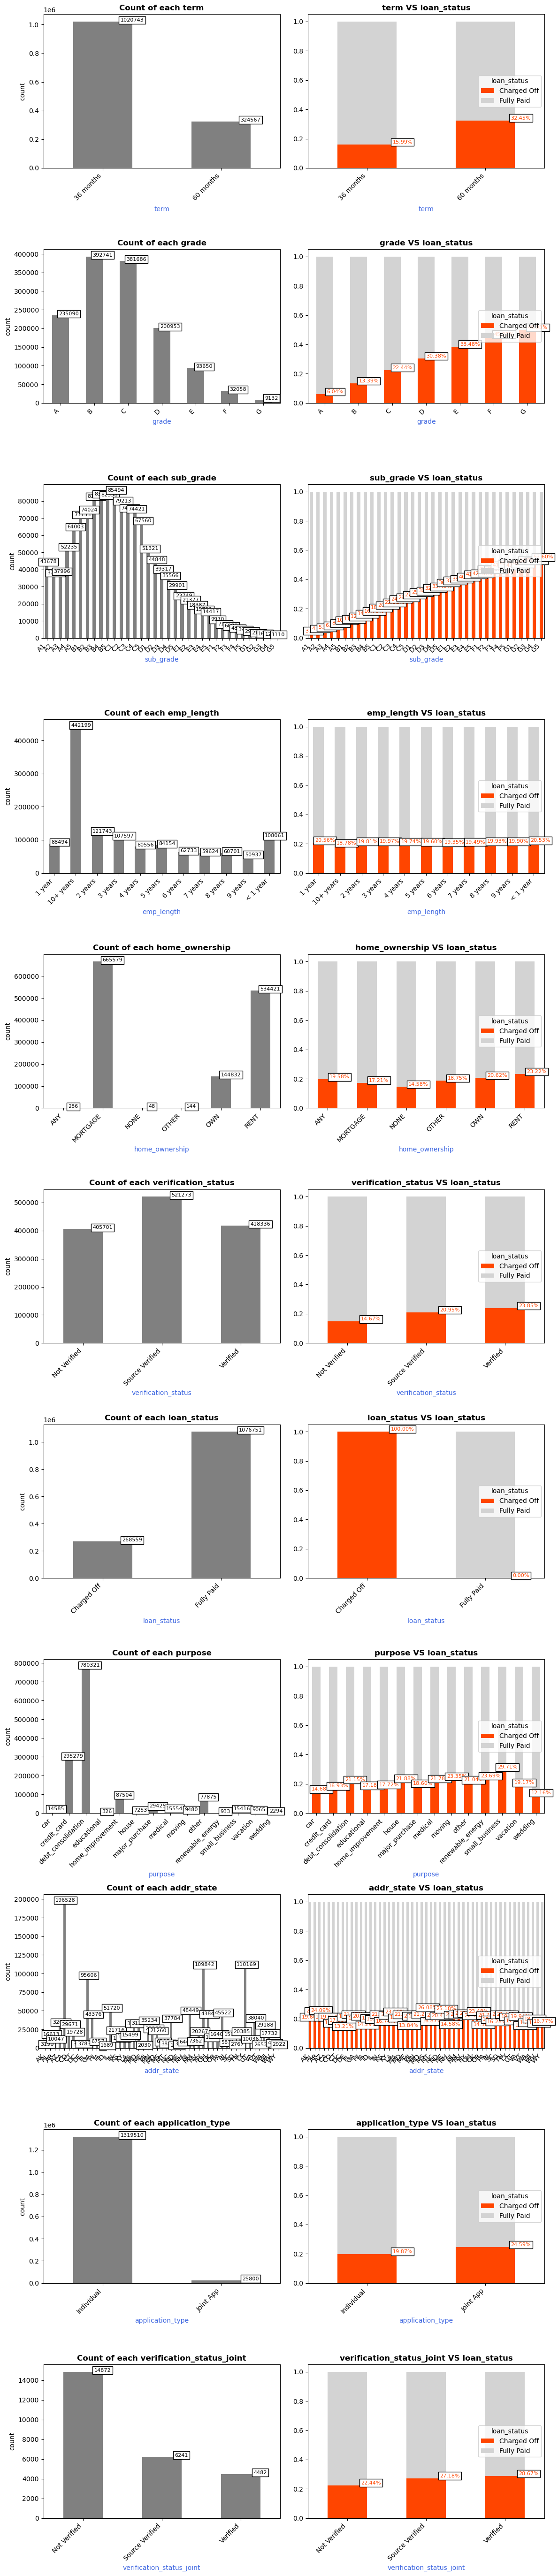

In [245]:
fig, ax = plt.subplots(len(cat), 2, figsize=(12, 5*len(cat)))
for idx, col in enumerate(cat):
    ax1 = sns.countplot(data=df_drop[cat], x=col, order=np.sort(df_drop[col].dropna().unique()), 
                        width=0.5, ax=ax[idx, 0], color='gray')
    ax1.set_title(f"Count of each {col}",size=12, weight="bold")
    font1 = {'color':'royalblue','size':10, 'rotation':360}
    ax1.set_xlabel(col, fontdict=font1)

    # 타겟에 대한 컬럼의 범주별 비율 계산
    prop_df = pd.crosstab(df_drop[col], df_drop[target], normalize='index')
    ax2 = prop_df.plot(kind='bar', stacked=True, ax=ax[idx, 1], color=['orangered','lightgray'])
    ax2.set_title(f"{col} VS {target}", size=12, weight="bold")
    font2 = { 'color':'royalblue','size':10, 'rotation':360}
    ax2.set_xlabel(col,fontdict=font2)
    ax2.legend(title=target, loc='center right')

    
    for bar1, bar2 in zip(ax1.patches, ax2.patches):
        bbox_props = dict(boxstyle="square,pad=0.3", edgecolor="black", facecolor="white")  # 네모 박스 스타일 정의
        ax1.text(bar1.get_x() + bar1.get_width(), bar1.get_height(), int(bar1.get_height()), 
                 ha="center", size=8,bbox=bbox_props)
        ax2.text(bar2.get_x() + bar2.get_width()+0.05 , bar2.get_height(), f'{bar2.get_height():.2%}',
                 ha='center', va='bottom', size=8, color='orangered',bbox=bbox_props)
        


# 눈금 레이블 회전 설정
set_xticklabels(ax[:, 0])
set_xticklabels(ax[:, 1])

# xticks 크기 조정
plt.xticks(fontsize=10)


plt.tight_layout()
plt.show()

In [246]:
cat

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state',
 'application_type',
 'verification_status_joint']

In [476]:
#grade의 세부 범위인 sub_grade만 제외
select_list1 = ['grade', 'term',  'emp_length', 'home_ownership', 'verification_status','addr_state', 'application_type','verification_status_joint']

## num

### 상관계수 select_list4

In [258]:
total_corr = df_drop[num].corr()

In [261]:
pd.set_option('display.max_rows', 100)

In [297]:
target_corr2 = pd.DataFrame(total_corr['binary_loan_status'][total_corr['binary_loan_status'] != 1].sort_values(ascending=True, key=np.abs))
low_corr_top20  = target_corr2.head(20)
drop_num1 = low_corr_top20.index.tolist()

In [693]:
target_corr2

,binary_loan_status
tot_coll_amt,-0.000446
total_il_high_credit_limit,-0.001271
num_tl_120dpd_2m,0.001295
num_tl_30dpd,0.002601
delinq_amnt,0.002800
chargeoff_within_12_mths,0.003175
total_bal_ex_mort,-0.003762
acc_now_delinq,0.003951
num_rev_accts,-0.005009
num_il_tl,0.006387


In [465]:
select_list4 = target_corr2.tail(30).index.tolist()

In [466]:
select_list4

['mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mths_since_recent_inq',
 'revol_util',
 'inq_last_6mths',
 'loan_amnt',
 'funded_amnt',
 'bc_util',
 'percent_bc_gt_75',
 'num_rev_tl_bal_gt_0',
 'num_actv_rev_tl',
 'tot_cur_bal',
 'total_bc_limit',
 'mort_acc',
 'tot_hi_cred_lim',
 'avg_cur_bal',
 'bc_open_to_buy',
 'dti',
 'num_tl_op_past_12m',
 'acc_open_past_24mths',
 'fico_range_high',
 'fico_range_low',
 'total_rec_late_fee',
 'sec_app_inq_last_6mths',
 'sec_app_mths_since_last_major_derog',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'int_rate',
 'last_fico_range_low',
 'last_fico_range_high']

### 숫자형 변수와 범주형 타겟 레이블 간의 ANOVA 테스트 수행 select_list2

- F-statistic (F-통계량): ANOVA 테스트에서 사용되는 통계량으로, 각 그룹의 평균 간의 차이를 나타냅니다. F-통계량이 클수록 그룹 간의 평균 차이가 크다는 것을 의미합니다.

- p-value (p-값): 통계적 가설 검정에서 귀무가설이 참일 확률을 나타냅니다. 여기서는 귀무가설이 "그룹 간의 평균에 유의한 차이가 없다"입니다.
- 작은 p-value는 귀무가설을 기각할 증거가 충분하다는 것을 의미합니다. 보통 0.05보다 작으면 유의미한 차이가 있다고 판단합니다.

In [274]:
num =['loan_amnt',
 'funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_rec_late_fee',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_inq_last_6mths',
 'sec_app_mths_since_last_major_derog']

In [292]:
from scipy.stats import f_oneway

drop_list8 = []
select_list2 = []
nan_list = []

for col in num:
    f_statistic, p_value = f_oneway(df[col][df[target] == 'Charged Off'],
                                     df[col][df[target] == 'Fully Paid'])
    print(f"ANOVA 결과 - 변수 '{col}': F-statistic={f_statistic}, p-value={p_value}")
    
    if p_value <= 0.5 :
        select_list2.append(col)
    elif p_value > 0.5 :
        drop_list8.append(col)

    else:
        nan_list.append(col)

    print("-"*50)

ANOVA 결과 - 변수 'loan_amnt': F-statistic=5815.067588504453, p-value=0.0
--------------------------------------------------
ANOVA 결과 - 변수 'funded_amnt': F-statistic=5824.627364984558, p-value=0.0
--------------------------------------------------
ANOVA 결과 - 변수 'int_rate': F-statistic=96566.86809469215, p-value=0.0
--------------------------------------------------
ANOVA 결과 - 변수 'installment': F-statistic=3605.6129973131956, p-value=0.0
--------------------------------------------------
ANOVA 결과 - 변수 'annual_inc': F-statistic=2350.112319835169, p-value=0.0
--------------------------------------------------
ANOVA 결과 - 변수 'dti': F-statistic=nan, p-value=nan
--------------------------------------------------
ANOVA 결과 - 변수 'delinq_2yrs': F-statistic=505.51479867404737, p-value=6.291796117702685e-112
--------------------------------------------------
ANOVA 결과 - 변수 'fico_range_low': F-statistic=23374.53697121506, p-value=0.0
--------------------------------------------------
ANOVA 결과 - 변수 'fico_

In [293]:
select_list2

['loan_amnt',
 'funded_amnt',
 'int_rate',
 'installment',
 'annual_inc',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'total_rec_late_fee',
 'last_fico_range_high',
 'last_fico_range_low',
 'acc_now_delinq',
 'delinq_amnt']

In [298]:
drop_num2 = nan_list

In [299]:
drop_num1

['tot_coll_amt',
 'total_il_high_credit_limit',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'delinq_amnt',
 'chargeoff_within_12_mths',
 'total_bal_ex_mort',
 'acc_now_delinq',
 'num_rev_accts',
 'num_il_tl',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'tax_liens',
 'num_tl_90g_dpd_24m',
 'num_accts_ever_120_pd',
 'pct_tl_nvr_dlq',
 'total_acc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq']

In [300]:
drop_num2

['dti',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens',
 'tot_hi_cred_lim',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'sec_app_fico_range_low',
 

In [302]:
same_drop_num = [col for col in drop_num1 if col in drop_num2]

In [303]:
same_drop_num

['tot_coll_amt',
 'total_il_high_credit_limit',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'chargeoff_within_12_mths',
 'total_bal_ex_mort',
 'num_rev_accts',
 'num_il_tl',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'tax_liens',
 'num_tl_90g_dpd_24m',
 'num_accts_ever_120_pd',
 'pct_tl_nvr_dlq',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq']

### 모델 기반 특성 선택 - 트리모델 특성 중요도 확인 select_list3, select_list5


In [384]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectPercentile

In [404]:
df_num = df_drop[num+[target]].dropna()

In [405]:
X, y = df_num.loc[:, [column for column in df_num.columns if column != "loan_status"]], df_num.loan_status

In [406]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.1, random_state=42, stratify=y_1)

In [408]:
### 특성을 고를 model 적용

randforest = RandomForestClassifier(n_estimators=100, random_state=0)
select_model = SelectFromModel(randforest, threshold='median').fit(X_train, y_train)

select_uni = SelectPercentile(percentile=50).fit(X_train, y_train)

In [413]:
# 선택된 특성들의 인덱스 가져오기
selected_features_index = select_model.get_support()  # 또는 select_uni.get_support()

# 선택된 특성들의 이름 가져오기 (예: X_train 데이터프레임의 열 이름)
selected_features_names = X_train.columns[selected_features_index]

# 선택된 특성들을 데이터프레임으로 확인
selected_features_df = X_train[selected_features_names]

In [419]:
len(selected_features_names)

29

In [461]:
select_list3 = selected_features_df.columns.tolist()

In [480]:
# SelectFromModel을 사용한 경우
selected_features = select_model.transform(X_train)

# 선택된 특성들의 중요도(특성 중요도) 확인
importances = select_model.estimator_.feature_importances_

# 각 특성의 중요도를 데이터프레임으로 변환하여 확인
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# 피처 중요도가 큰 순으로 정렬
select_list5= importance_df.sort_values(by='Importance', ascending=False).head(30).Feature.tolist()

### 박스플롯 시각화 select_list6 / outlier_num

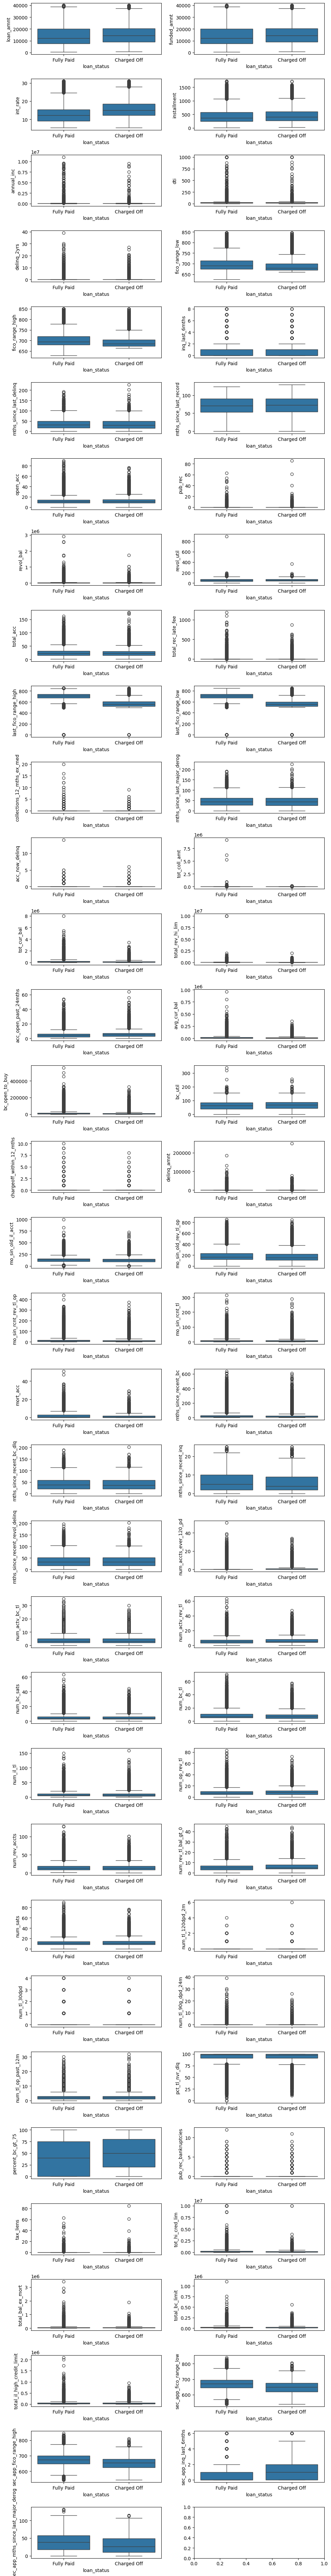

In [343]:
fig, ax = plt.subplots(round(len(num)/2),2, figsize=(10, len(num)+10))
for idx, col in enumerate(num):
    if idx % 2 == 0 :
        sns.boxplot(data=df_drop, y=col, x=target, ax= ax[idx // 2,0])
    else :
        sns.boxplot(data=df_drop, y=col, x=target, ax =ax[idx // 2,1])
        
plt.tight_layout()
plt.show()

In [357]:
from sklearn.preprocessing import PowerTransformer

In [348]:
#scale처리가 필요한 num feature
scale = ['annual_inc', 'dti', 'delinq_2yrs', 'pub_rec', 'revol_bal', 'total_acc', 
         'total_rec_late_fee', 'collections_12_mths_ex_med', 'acc_now_delinq',
         'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 
         'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
         'num_accts_ever_120_pd', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 
         'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit' , 'total_il_high_credit_limit']

In [371]:
scaled = df_drop[scale+[target]]
scaled = scaled.dropna()

In [374]:
#파워 스케일링 적용
scaler = make_column_transformer((PowerTransformer(), scale),
                              remainder='passthrough',
                              verbose_feature_names_out=False,
                                )

In [375]:
scaled_num = scaler.fit_transform(scaled)

In [376]:
scaled_df = pd.DataFrame(data=scaled_num, columns=scaler.get_feature_names_out().tolist())

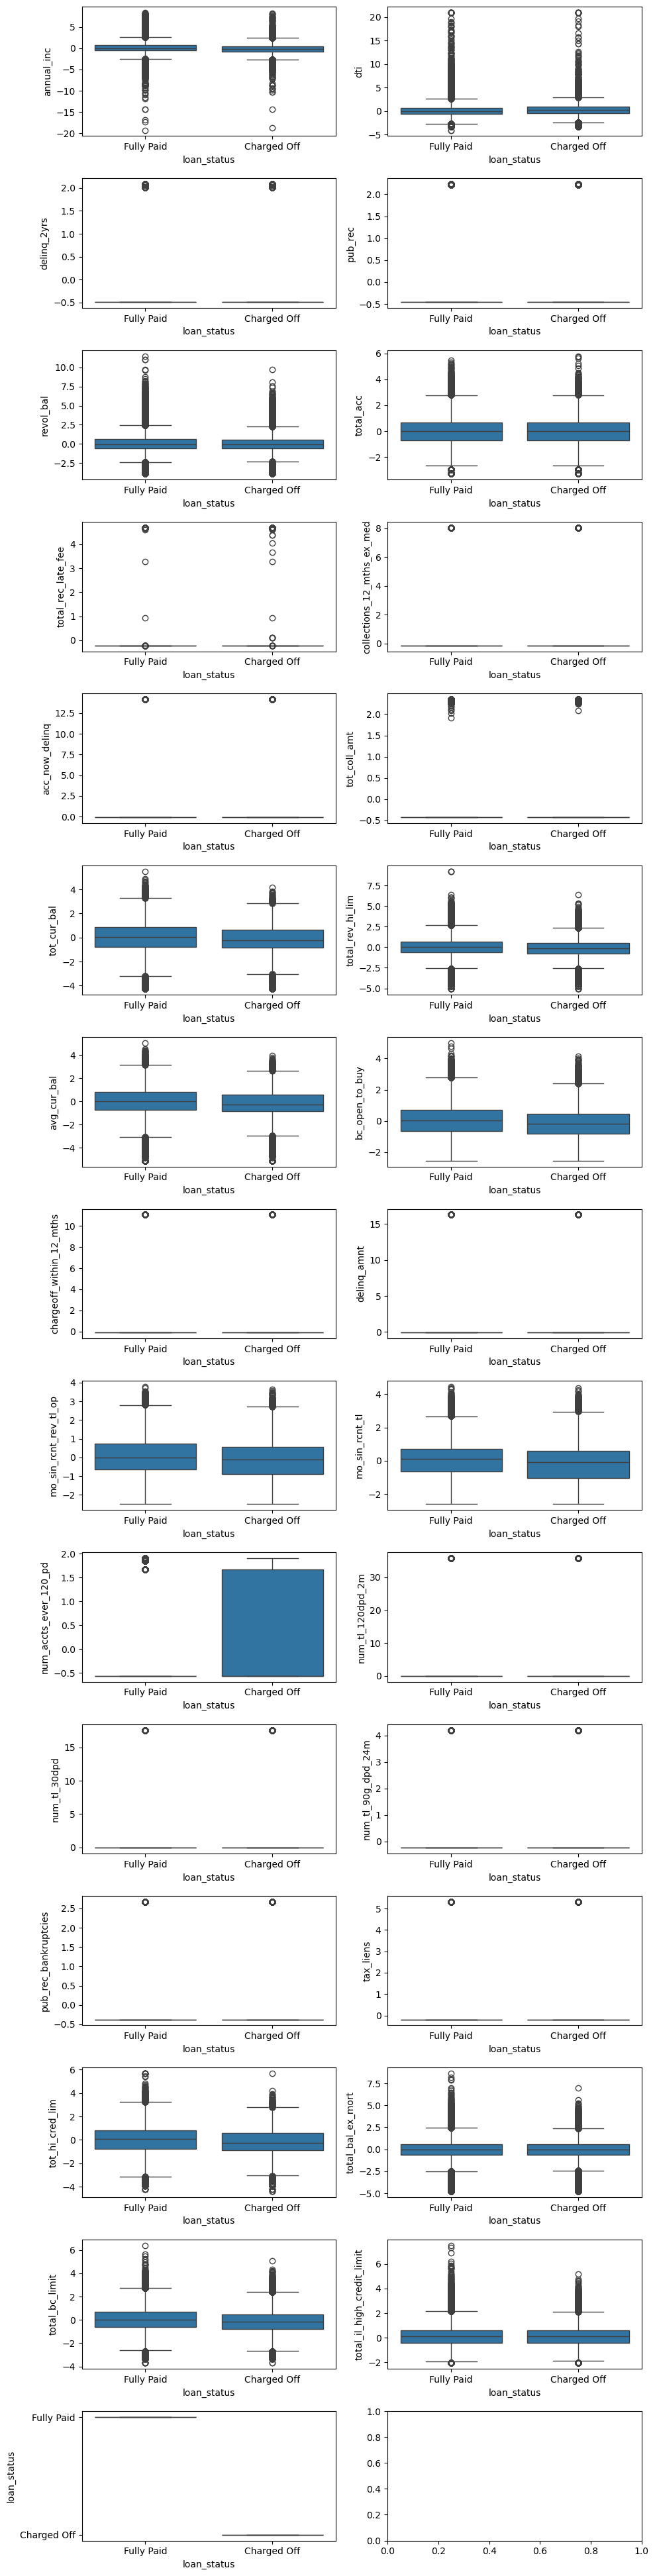

In [379]:
fig, ax = plt.subplots(round(len(scaled_df.columns)/2)+1,2, figsize=(10, len(scaled_df.columns)+10))
for idx, col in enumerate(scaled_df.columns):
    if idx % 2 == 0 :
        sns.boxplot(data=scaled_df, y=col, x=target, ax= ax[idx // 2,0])
    else :
        sns.boxplot(data=scaled_df, y=col, x=target, ax =ax[idx // 2,1])
        
plt.tight_layout()
plt.show()

In [483]:
#박스플롯 타겟별 차이를 보이는 변수
select_list6 = ['int_rate', 'loan_amnt', 'fico_range_low','fico_range_high','last_fico_range_high', 'last_fico_range_high', 
                'acc_open_past_24mths', 'bc_util', 'mo_sin_old_il_acct' ,'mo_sin_old_rev_tl_op', 'mort_acc', 'mths_since_recent_bc', 
                'mths_since_recent_inq', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'sec_app_fico_range_low','sec_app_fico_range_high', 
                'sec_app_inq_last_6mths', 'sec_app_mths_since_last_major_derog','annual_inc', 'dti', 'tot_cur_bal', 
                'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'num_accts_ever_120_pd','tot_hi_cred_lim','total_bc_limit']

In [487]:
len(select_list6)

35

In [431]:
#분산이 적은 컬럼(거의 평균, 중앙값 0)
outlier_num = ['delinq_2yrs', 'pub_rec', 'total_rec_late_fee', 'collections_12_mths_ex_med', 'acc_now_delinq', 
               'tot_coll_amt','chargeoff_within_12_mths', 'delinq_amnt',
               'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies',  'tax_liens']

## num selection 종합 (연체 체납 제외 17개 특성) select_list7

In [490]:
select_list2 #아노바 분석 결과
select_list3 #모델 기반 결과
select_list4 #상관관계분석 top30
select_list5 #특성중요도 탑 30
select_list6 #박스플롯 타겟별 차이를 보이는 변수리스트

['int_rate',
 'loan_amnt',
 'fico_range_low',
 'fico_range_high',
 'last_fico_range_high',
 'last_fico_range_high',
 'acc_open_past_24mths',
 'bc_util',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_actv_rev_tl',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_inq_last_6mths',
 'sec_app_mths_since_last_major_derog',
 'annual_inc',
 'dti',
 'tot_cur_bal',
 'avg_cur_bal',
 'bc_open_to_buy',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'num_accts_ever_120_pd',
 'tot_hi_cred_lim',
 'total_bc_limit']

In [504]:
set1

{'acc_now_delinq',
 'annual_inc',
 'delinq_2yrs',
 'delinq_amnt',
 'fico_range_high',
 'fico_range_low',
 'funded_amnt',
 'installment',
 'int_rate',
 'last_fico_range_high',
 'last_fico_range_low',
 'loan_amnt',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'total_acc',
 'total_rec_late_fee'}

common_elements = set1.intersection(set5)
print("공통 특성:", common_elements)

In [518]:
# 각 리스트를 집합(set)으로 변환
set1 = set(select_list2)
set2 = set(select_list3) #모델 기반 결과
set3 = set(select_list4) #상관관계분석 top30
#set4 = set(select_list5) #특성중요도 탑 30
set5 = set(select_list6)

# 각 리스트의 원소들의 공통 인수를 찾음
common_elements = set2.intersection(set3, set4)

# 결과 출력
print("공통 특성:", common_elements)

공통 특성: {'bc_open_to_buy', 'fico_range_high', 'loan_amnt', 'last_fico_range_low', 'tot_cur_bal', 'avg_cur_bal', 'total_rec_late_fee', 'mo_sin_rcnt_rev_tl_op', 'revol_util', 'fico_range_low', 'int_rate', 'tot_hi_cred_lim', 'bc_util', 'funded_amnt', 'total_bc_limit', 'dti', 'last_fico_range_high'}


In [519]:
len(common_elements)

17

In [543]:
#num종합(연체, 체납 관련 컬럼 제외)
select_list7=list(common_elements)

## 연체/체납 관련 컬럼 이상치 탐색 결과 (연체 체납 관련 8개 특성) select_list8

1. 연체/체납 이력이 있는 사람들(1이상 값을 가진) 중 대부분이 1회인 경우의 컬럼(하한값, 상한값 모두 1인 경우)이면서 그 외의 값이 적은경우  
**0(이력 없음) / 1(이력 있음) 으로 특성 엔지니어링**

    - num_tl_30dpd -> 여부 (단기 연체 여부)
    - acc_now_deliq -> 여부 (현재 연체 계좌 여부)
    - collections_12_mths_ex_med -> 여부 (12개월 내 소액_채권 체납 여부 (의료 제외))  
    - chargeoff_within_12_mths -> 여부 (12개월 내 채무불능 여부)
    - pub_rec 


----    

2.  1이상 값들 중에서 상한값이 2이상인 컬럼 : 0,1,2로 오디널 인코딩(범주화)
   - delinq_2yrs
   - tax_liens 



----
3. 연체/체납 이력이 있는 갯수가 일치하는 컬럼이 없음  
ex) 체납 누적 횟수(pub_rec, tax_liens) <-> 총 체납 누적금액(tot_coll_amt) 의 관계  
1이상의 값 개수 : tax_liens < tot_coll_amt < pub_rec   

**더 큰 범위이거나 서로 다른 의미의 컬럼으로 판단되어짐**


In [545]:
outlier_num

['delinq_2yrs',
 'pub_rec',
 'total_rec_late_fee',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'tax_liens']

In [ ]:
'pub_rec_bankruptcies'

In [531]:
set8= outlier_num

In [538]:
#아노바 분석결과와 공통 특성
common_element1 = set1.intersection(set8)

In [569]:
select_list8 = list(common_element1)
select_list8

['acc_now_delinq',
 'delinq_amnt',
 'delinq_2yrs',
 'pub_rec',
 'total_rec_late_fee']

In [570]:
select_list8.extend(['num_tl_30dpd','chargeoff_within_12_mths', 'tax_liens'])

In [571]:
select_list8

['acc_now_delinq',
 'delinq_amnt',
 'delinq_2yrs',
 'pub_rec',
 'total_rec_late_fee',
 'num_tl_30dpd',
 'chargeoff_within_12_mths',
 'tax_liens']

# total feature selection

In [638]:
total_feature = select_list1+select_list7+select_list8
total_feature = set(total_feature)
total_feature = list(total_feature)


In [639]:
print(total_feature)

['application_type', 'verification_status', 'acc_now_delinq', 'loan_amnt', 'tot_cur_bal', 'emp_length', 'home_ownership', 'int_rate', 'tax_liens', 'funded_amnt', 'num_tl_30dpd', 'addr_state', 'chargeoff_within_12_mths', 'total_rec_late_fee', 'mo_sin_rcnt_rev_tl_op', 'tot_hi_cred_lim', 'term', 'total_bc_limit', 'dti', 'delinq_amnt', 'delinq_2yrs', 'verification_status_joint', 'last_fico_range_low', 'avg_cur_bal', 'last_fico_range_high', 'bc_open_to_buy', 'fico_range_high', 'pub_rec', 'grade', 'revol_util', 'fico_range_low', 'bc_util']


In [574]:
make_na_table(total_feature, df=df)

+---------------------------+-------------+-----------+
|           변수명          | 결측치 개수 | 전체 비율 |
+---------------------------+-------------+-----------+
|           grade           |      0      |   0.00%   |
|            term           |      0      |   0.00%   |
|         emp_length        |    78511    |   5.84%   |
|       home_ownership      |      0      |   0.00%   |
|    verification_status    |      0      |   0.00%   |
|         addr_state        |      0      |   0.00%   |
|      application_type     |      0      |   0.00%   |
| verification_status_joint |   1319715   |   98.10%  |
|       bc_open_to_buy      |    61143    |   4.54%   |
|      fico_range_high      |      0      |   0.00%   |
|         loan_amnt         |      0      |   0.00%   |
|    last_fico_range_low    |      0      |   0.00%   |
|        tot_cur_bal        |    67527    |   5.02%   |
|        avg_cur_bal        |    67549    |   5.02%   |
|     total_rec_late_fee    |      0      |   0.00%   |
|   

# Model Train

In [641]:
df_1 = df[total_feature + [target]].copy()

In [642]:
df_1['verification_status_joint'].fillna('NONE', inplace=True)

In [643]:
df_1.dropna(axis = 0, inplace=True)

In [644]:
df_1.shape

(1188197, 33)

In [645]:
X, y = df_1.loc[:, [column for column in df_1.columns if column != "loan_status"]], df_1.loan_status
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y_1)

In [604]:
import xgboost
import lightgbm
import catboost
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score, matthews_corrcoef, fbeta_score, make_scorer

def impute_score(imputer, X_missing, y_missing):
    score_xgb = cross_validate(Pipeline([("imputer", imputer), 
                                         ("classifier", classifier_xgb)]), 
                               X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                              "PRC-AUC (AP)": "average_precision", 
                                                              "ROC-AUC": "roc_auc", 
                                                              "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                              "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                              "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)
    score_lgbm = cross_validate(Pipeline([("imputer", imputer), 
                                          ("classifier", classifier_lgbm)]), 
                                X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                               "PRC-AUC (AP)": "average_precision", 
                                                               "ROC-AUC": "roc_auc", 
                                                               "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                               "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                               "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)
    score_cat = cross_validate(Pipeline([("imputer", imputer), 
                                         ("classifier", classifier_cat)]), 
                               X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                              "PRC-AUC (AP)": "average_precision", 
                                                              "ROC-AUC": "roc_auc", 
                                                              "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                              "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                              "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)

    df_xgb = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_xgb.items() if "train" in key] + [score_xgb.get("fit_time").mean().round()], 
                                     "test": [value.mean().round(4) for key, value in score_xgb.items() if "test" in key] + [score_xgb.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    df_lgbm = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_lgbm.items() if "train" in key] + [score_lgbm.get("fit_time").mean().round()], 
                                      "test": [value.mean().round(4) for key, value in score_lgbm.items() if "test" in key] + [score_lgbm.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    df_cat = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_cat.items() if "train" in key] + [score_cat.get("fit_time").mean().round()], 
                                     "test": [value.mean().round(4) for key, value in score_cat.items() if "test" in key] + [score_cat.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    
    df_xgb.columns = [["XGBClassifier", "XGBClassifier"], ["train", "test"]]
    df_lgbm.columns = [["LGBMClassifier", "LGBMClassifier"], ["train", "test"]]
    df_cat.columns = [["CatBoostClassifier", "CatBoostClassifier"], ["train", "test"]]
    return pd.concat((df_xgb, df_lgbm, df_cat), axis=1)
    
classifier_xgb = xgboost.XGBClassifier(verbosity=3, tree_method="hist", n_jobs=-1, random_state=6, eval_metric=average_precision_score)
classifier_lgbm = lightgbm.LGBMClassifier(random_state=6, n_jobs=-1, verbosity=2, metric="average_precision")
classifier_cat = catboost.CatBoostClassifier(verbose=3, eval_metric="PRAUC", random_state=6)

In [646]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
label.fit(y_train)
label.classes_ = np.array(["Fully Paid", "Charged Off"], dtype=np.object_)
y_train_label = label.transform(y_train)

In [612]:
select_list1

['grade',
 'term',
 'emp_length',
 'home_ownership',
 'verification_status',
 'addr_state',
 'application_type',
 'verification_status_joint']

In [647]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder,StandardScaler
from sklearn.preprocessing import RobustScaler

num_feature = X_train.select_dtypes(include=np.number).columns.tolist()
cat_feature = X_train.select_dtypes(exclude=np.number).columns.tolist()

In [680]:


num_feature = ['acc_now_delinq',
                 'loan_amnt',
                 'tot_cur_bal',
                 'int_rate',
                 'tax_liens',
                 'funded_amnt',
                 'num_tl_30dpd',
                 'chargeoff_within_12_mths',
                 'total_rec_late_fee',
                 'mo_sin_rcnt_rev_tl_op',
                 'tot_hi_cred_lim',
                 'total_bc_limit',
                 'dti',
                 'delinq_amnt',
                 'delinq_2yrs',
                 'avg_cur_bal',
                 'bc_open_to_buy',
                 'fico_range_high',
                 'pub_rec',
                 'revol_util',
                 'fico_range_low',
                 'bc_util']

In [681]:
preprocessing = ColumnTransformer(transformers=[
                                    ('cat', OneHotEncoder(), cat_feature),
                                    ('num', PowerTransformer(), num_feature)],
                                                            remainder='drop', n_jobs=-1, verbose_feature_names_out=False)

In [650]:
X_train_pre = preprocessing.fit_transform(X_train)

In [682]:
from sklearn.pipeline import Pipeline,make_pipeline

pipe =  Pipeline(steps=[('pre',preprocessing),('model', classifier_xgb)])



In [683]:
pipe.fit(X_train, y_train_label)

Pipeline(steps=[('pre',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['application_type',
                                                   'verification_status',
                                                   'emp_length',
                                                   'home_ownership',
                                                   'addr_state', 'term',
                                                   'verification_status_joint',
                                                   'grade']),
                                                 ('num', PowerTransformer(),
                                                  ['acc_now_delinq',
                                                   'loan_amnt', 'tot_cur_bal',
                                                   'int_rate', 'tax_liens',
                                                   'funded_amnt',
                                                   'num_tl_30dpd',
                                                   'chargeoff...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=6, ...))])

In [684]:
pipe.score(X_train, y_train_label)

0.8201789741532918

In [663]:
pipe.score(X_train, y_train_label)

0.9190776453260919

In [664]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
label.fit(y_test)
label.classes_ = np.array(["Fully Paid", "Charged Off"], dtype=np.object_)
y_test_label = label.transform(y_test)

In [670]:
y_pred = pipe.predict(X_test)

In [685]:
y_pred = pipe.predict(X_test)

In [686]:
# last_fico_range 제거
# 모델의 예측을 평가하여 점수(성능 지표) 확인
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# 분류 정확도 계산
accuracy = accuracy_score(y_test_label, y_pred)
print("분류 정확도:", accuracy)

report = classification_report(y_test_label, y_pred)
print("분류 보고서:")
print(report)

roc_auc = roc_auc_score(y_test_label, y_pred)
print(roc_auc)

분류 정확도: 0.8141979464736576
분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    190673
           1       0.60      0.17      0.27     46967

    accuracy                           0.81    237640
   macro avg       0.72      0.57      0.58    237640
weighted avg       0.78      0.81      0.77    237640

0.5728240462723104


In [691]:
# last_fico_range 
# 모델의 예측을 평가하여 점수(성능 지표) 확인
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,precision_score

# 분류 정확도 계산
accuracy = accuracy_score(y_test_label, y_pred)
print("분류 정확도:", accuracy)

report = classification_report(y_test_label, y_pred)
print("분류 보고서:")
print(report)

roc_auc = roc_auc_score(y_test_label, y_pred)
print(roc_auc)


precision = precision_score(y_test_label, y_pred)
print("Precision:", precision)

분류 정확도: 0.8141979464736576
분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89    190673
           1       0.60      0.17      0.27     46967

    accuracy                           0.81    237640
   macro avg       0.72      0.57      0.58    237640
weighted avg       0.78      0.81      0.77    237640

0.5728240462723104
Precision: 0.6041774683356789


In [622]:
import xgboost
import lightgbm
import catboost
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score, matthews_corrcoef, fbeta_score, make_scorer

def impute_score(imputer, X_missing, y_missing):
    score_xgb = cross_validate(Pipeline([("imputer", imputer), 
                                         ("classifier", classifier_xgb)]), 
                               X_missing, y_missing, scoring={"MCC" : make_scorer(matthews_corrcoef), 
                                                              "PRC-AUC (AP)": "average_precision", 
                                                              "ROC-AUC": "roc_auc", 
                                                              "F-2 Score": make_scorer(fbeta_score, beta=2), 
                                                              "F-1.5 Score": make_scorer(fbeta_score, beta=1.5), 
                                                              "F-1 Score": "f1"}, cv=3, n_jobs=-1, verbose=1000, return_train_score=True)
   
    df_xgb = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_xgb.items() if "train" in key] + [score_xgb.get("fit_time").mean().round()], 
                                     "test": [value.mean().round(4) for key, value in score_xgb.items() if "test" in key] + [score_xgb.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    #df_lgbm = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_lgbm.items() if "train" in key] + [score_lgbm.get("fit_time").mean().round()], 
                                      #"test": [value.mean().round(4) for key, value in score_lgbm.items() if "test" in key] + [score_lgbm.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    #df_cat = pd.DataFrame.from_dict({"train": [value.mean().round(4) for key, value in score_cat.items() if "train" in key] + [score_cat.get("fit_time").mean().round()], 
                                    # "test": [value.mean().round(4) for key, value in score_cat.items() if "test" in key] + [score_cat.get("score_time").mean().round()]}).set_axis(["MCC", "PRC-AUC (AP)", "ROC-AUC", "F-2 Score", "F-1.5 Score", "F-1 Score", "fit_time, score_time"], axis=0)
    
    df_xgb.columns = [["XGBClassifier", "XGBClassifier"], ["train", "test"]]
   # df_lgbm.columns = [["LGBMClassifier", "LGBMClassifier"], ["train", "test"]]
   # df_cat.columns = [["CatBoostClassifier", "CatBoostClassifier"], ["train", "test"]]
    return df_xgb
    
classifier_xgb = xgboost.XGBClassifier( n_jobs=-1, random_state=6, eval_metric=average_precision_score)
#classifier_lgbm = lightgbm.LGBMClassifier(random_state=6, n_jobs=-1, verbosity=2, metric="average_precision")
#classifier_cat = catboost.CatBoostClassifier(verbose=3, eval_metric="PRAUC", random_state=6)


In [607]:
import xgboost

In [610]:
classifier_xgb = xgboost.XGBClassifier( n_jobs=-1, random_state=42)

In [626]:
X_train.columns

Index(['grade', 'term', 'emp_length', 'home_ownership', 'verification_status',
       'addr_state', 'application_type', 'verification_status_joint',
       'bc_open_to_buy', 'fico_range_high', 'loan_amnt', 'last_fico_range_low',
       'tot_cur_bal', 'avg_cur_bal', 'total_rec_late_fee',
       'total_rec_late_fee', 'mo_sin_rcnt_rev_tl_op', 'revol_util',
       'fico_range_low', 'int_rate', 'tot_hi_cred_lim', 'bc_util',
       'funded_amnt', 'total_bc_limit', 'dti', 'last_fico_range_high',
       'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'pub_rec',
       'total_rec_late_fee', 'total_rec_late_fee', 'num_tl_30dpd',
       'chargeoff_within_12_mths', 'tax_liens'],
      dtype='object')

In [651]:
impute_score(preprocessing, X_train, y_train_label)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   53.9s finished


XGBClassifier     
                             train test
MCC                         0.7516  NaN
PRC-AUC (AP)                0.8752  NaN
ROC-AUC                     0.9655  NaN
F-2 Score                   0.8043  NaN
F-1.5 Score                 0.8031  NaN
F-1 Score                   0.8010  NaN
fit_time, score_time       34.0000  4.0

In [17]:
혜영 = sorted(['grade', 'term', 'emp_length', 'home_ownership', 'verification_status', 'addr_state', 'application_type', 'verification_status_joint', 'bc_open_to_buy', 'fico_range_high', 'loan_amnt', 'last_fico_range_low', 'tot_cur_bal', 'avg_cur_bal', 'total_rec_late_fee', 'mo_sin_rcnt_rev_tl_op', 'revol_util', 'fico_range_low', 'int_rate', 'tot_hi_cred_lim', 'bc_util', 'funded_amnt', 'total_bc_limit', 'dti', 'last_fico_range_high', 'acc_now_delinq', 'delinq_amnt', 'delinq_2yrs', 'pub_rec', 'total_rec_late_fee', 'num_tl_30dpd', 'chargeoff_within_12_mths', 'tax_liens'])

용현 = sorted(['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'policy_code', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_cur_bal', 'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_mort_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts'])

요한 = sorted(["emp_length", "home_ownership", "annual_inc", "verification_status", "addr_state", "dti", "pub_rec_bankruptcies", "pub_rec", "inq_last_6mths", "mths_since_recent_inq", "mo_sin_old_il_acct", "num_il_tl", "total_il_high_credit_limit", "revol_bal", "revol_util", "total_rev_hi_lim", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "num_actv_rev_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0", "mort_acc", "open_acc", "total_acc", "tot_cur_bal", "acc_open_past_24mths", "avg_cur_bal", "mo_sin_rcnt_tl", "num_accts_ever_120_pd", "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m", "num_tl_op_past_12m", "pct_tl_nvr_dlq", "tot_hi_cred_lim", "total_bal_ex_mort", "collections_12_mths_ex_med", "delinq_2yrs", "acc_now_delinq", "tot_coll_amt", "delinq_amnt", "tax_liens", "chargeoff_within_12_mths", "purpose", "loan_amnt", "term", "fico_range_low", "fico_range_high"])

규리 = sorted(["verification_status", "total_il_high_credit_limit", "total_cu_tl,total_bc_limit", "total_bal_il","total_bal_ex_mort", "total_acc","tot_hi_cred_lim", "tot_cur_bal", "term", "tax_liens", "pub_rec_bankruptcies", "percent_bc_gt_75", "pct_tl_nvr_dlq", "open_rv_24m", "open_rv_12m", "open_il_24m", "open_il_12m", "open_act_il", "open_acc_6m", "num_tl_op_past_12m", "open_rv_12m", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_sats", "num_rev_tl_bal_gt_0", "num_rev_accts", "num_op_rev_tl", "num_il_tl", "num_bc_tl", "num_bc_sats", "num_actv_rev_tl", "num_actv_bc_tl", "num_accts_ever_120_pd", "mths_since_recent_revol_delinq", "mths_since_recent_inq", "mths_since_recent_bc_dlq", "mths_since_recent_bc", "mths_since_rcnt_il", "mths_since_last_major_derog", "mort_acc", "mo_sin_rcnt_tl", "mo_sin_rcnt_rev_tl_op", "mo_sin_old_rev_tl_op", "mo_sin_old_il_acct", "max_bal_bc", "loan_amnt", "last_credit_pull_d", "int_rateinq_last_12m", "inq_fi", "il_util", "home_ownership", "grade", "emp_length", "delinq_amnt", "collections_12_mths_ex_med", "chargeoff_within_12_mths", "bc_util", "bc_open_to_buy", "avg_cur_bal", "annual_inc", "all_util", "acc_open_past_24mths", "acc_now_delinq", "addr_state", "delinq_2yrs", "dti", "earliest_cr_line", "last_fico_range_low", "mths_since_last_delinq", "open_acc", "pub_rec", "purpose", "revol_bal", "revol_util", "total_rev_hi_lim"])

sum_list = 혜영 + 용현 + 요한 + 규리

[column for column in df.columns if sum_list.count(column) == 1]




['funded_amnt',
 'int_rate',
 'pymnt_plan',
 'zip_code',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'last_credit_pull_d',
 'last_fico_range_high',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'tot_coll_amt',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'open_rv_24m',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'num_actv_bc_tl',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_mort_acc',
 'sec_app_revol_util',
 'sec_app_num_rev_accts']

<Axes: >

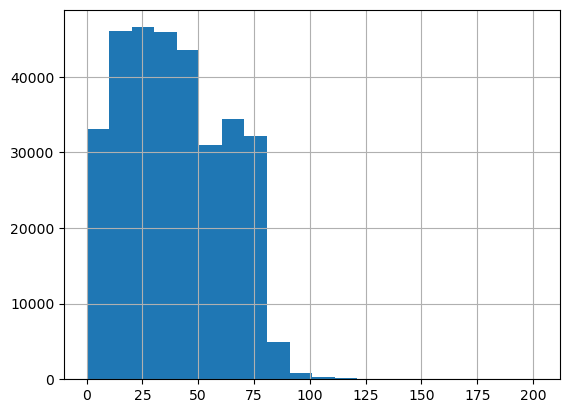

In [31]:
df['mths_since_recent_bc_dlq'].hist(bins=20)

In [33]:
df['application_type'].value_counts()

application_type
Individual    1319510
Joint App       25800
Name: count, dtype: int64

In [699]:
df[['num_tl_30dpd', 'loan_status']].groupby(target).value_counts()

loan_status  num_tl_30dpd
Charged Off  0.0              257334
             1.0                 857
             2.0                  42
             3.0                   7
             4.0                   1
Fully Paid   0.0             1016341
             1.0                3031
             2.0                 145
             3.0                  19
             4.0                   6
Name: count, dtype: int64